<a href="https://colab.research.google.com/github/shainedl/Papers-Colab/blob/master/Variational_Principal_Components_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.distributions as tdist
from torch.distributions.multivariate_normal import MultivariateNormal as multivariate_normal
import math

In [0]:
class BayesianPCA():
  
  def __init__(self, a_alpha=10e-3, b_alpha=10e-3, a_tau=10e-3, b_tau=10e-3, beta=10e-3):
    
    # hyperparameters
    self.a_alpha = a_alpha
    self.b_alpha = b_alpha
    self.a_tau = a_tau
    self.b_tau = b_tau
    self.beta = beta 
    
  def __get_elbo(self):
    """
    Computes the rigorous lower bound on the true log marginal likelihood 
    
    Returns
    -------
      float
        the lower bound = prior + likelihood - entropy 
    
    """                             
    # random sample
    x = torch.stack([multivariate_normal(self.mean_x[:,n], self.sigma_x).sample() for n in range(self.N)]).t()
    mu = multivariate_normal(self.mean_mu.flatten(), self.sigma_mu).sample()
    w = torch.stack([self.__reparameterize(self.mean_w[i,:], self.sigma_w[:,0]) for i in range(self.d)])
    alpha = tdist.gamma.Gamma(self.a_alpha_tilde, self.b_alpha_tilde).sample()     
    tau = tdist.gamma.Gamma(self.a_tau_tilde, self.b_tau_tilde).sample()

    # priors
    # p(x) = N(x|0,I_q)
    prior = torch.sum(torch.stack([multivariate_normal(torch.zeros(self.q, dtype=torch.float64), \
              torch.eye(self.q, dtype=torch.float64)).log_prob(x[:,i]) for i in range(self.N)]))
    # p(w|alpha) = conditional distribution                   
    prior += torch.sum(torch.stack([(self.d / 2) * torch.log(alpha[i] / \
              (2 * math.pi)) - 0.5 * alpha[i] * torch.sum(w[:,i]**2) \
              for i in range(self.q)]))                                      
    # p(alpha) = Gamma(a, b)                             
    prior += torch.sum((tdist.gamma.Gamma(self.a_alpha, self.b_alpha)).log_prob(alpha))                                  
    # p(mu) = N(mu|0,Beta^-1I)       
    prior += multivariate_normal(torch.zeros(self.d, dtype=torch.float64), torch.eye(self.d, dtype=torch.float64)/self.beta).log_prob(mu) 
    # p(tau) = Gamma(c, d)      
    prior += torch.sum((tdist.gamma.Gamma(self.a_tau, self.b_tau)).log_prob(tau))            
    
    # log likelihood of the conditional distribution 
    # p(t_n | x_n, W, mu, tau)
    w_x = torch.mm(w, x)
    list_t = []
    for n in range(self.N):
      list_t.append(w_x[:,n] + mu)
    likelihood = torch.sum(torch.stack([multivariate_normal(torch.stack(list_t).t()[:,n], \
                  torch.eye(self.d, dtype=torch.float64) / tau).log_prob(self.t_n[:,n]) for n in range(self.N)]))   
    
    # entropy
    # q(x) 
    entropy = self.N * (0.5 * torch.log((torch.cholesky(self.sigma_x).diag().prod()**2) \
                + (self.d / 2) * (1 + torch.log(torch.DoubleTensor([2 * math.pi])))))   
                  
    # q(mu)
    entropy += 0.5 * torch.log((torch.cholesky(self.sigma_mu).diag().prod()**2) \
                + (self.d / 2) * torch.log(torch.DoubleTensor([2 * math.pi])))
                
    # q(W)   
    entropy += self.d * (0.5 * torch.log((torch.cholesky(self.sigma_w).diag().prod()**2) \
                + (self.d / 2) * torch.log(torch.DoubleTensor([2 * math.pi]))))  
                  
    # q(alpha)
    entropy += self.q * (torch.log(torch.lgamma(torch.DoubleTensor([self.a_alpha_tilde])).exp()) \
                        - (self.a_alpha_tilde - 1) \
                        * torch.digamma(torch.DoubleTensor([self.a_alpha_tilde])) + self.a_alpha_tilde)
    for i in range(self.q):
      entropy -= torch.log(self.b_alpha_tilde[i])
                 
    # q(tau)  
    entropy += -1*(torch.DoubleTensor([self.a_tau_tilde - 1]) * torch.digamma(torch.DoubleTensor([self.a_tau_tilde])) \
               - torch.log(torch.DoubleTensor([self.b_tau_tilde])) + torch.DoubleTensor([self.a_tau_tilde]))
    # will ignore torch.log(torch.lgamma(torch.Tensor([self.a_tau_tilde])).exp()) since = inf

    return prior + likelihood - entropy 
  
  def __reparameterize(self, mean, sigma):
    eps = torch.randn_like(sigma)
    return mean + eps*sigma
  
  def fit(self, t_n, epochs = 3):
    """
    Fits the data
    
    Parameters 
    ----------
    t_n : d x N matrix
      observed data to be fit
      
    iterations: int
      number of iterations to re-estimate the lower bound
    
    threshold: float
      determines convergence
      
    """
    self.t_n = t_n
    self.d = self.t_n.shape[0]                     
    self.q = self.d - 1
    self.N = self.t_n.shape[1]   
    
    # variational parameters
    self.mean_x = torch.randn(self.q, self.N, dtype=torch.float64)
    self.sigma_x = torch.eye(self.q, dtype=torch.float64)
    self.mean_mu = torch.randn(self.d, 1, dtype=torch.float64)
    self.sigma_mu = torch.eye(self.d, dtype=torch.float64)
    self.mean_w = torch.randn(self.d, self.q, dtype=torch.float64)
    self.sigma_w = torch.eye(self.q, dtype=torch.float64)
    self.a_alpha_tilde = self.a_alpha + self.d / 2
    self.b_alpha_tilde = torch.abs(torch.randn(self.q, dtype=torch.float64))
    self.a_tau_tilde = (self.a_tau + self.N * self.d / 2)
    self.b_tau_tilde = torch.abs(torch.randn(1, dtype=torch.float64))
    self.mean_w.requires_grad_()
    
    for epoch in range(epochs):
      lr = 0.5
      elbo = self.__get_elbo()
      loss = -elbo
      loss.backward()
      with torch.no_grad():
        self.mean_w -= self.mean_w.grad * lr
        self.mean_w.grad.zero_()

In [0]:
import numpy as np 
import matplotlib.pyplot as plt

def hinton(matrix, max_weight=None, ax=None):
    """
    Draw Hinton diagram for visualizing a weight matrix.
    From https://matplotlib.org/3.1.1/gallery/specialty_plots/hinton_demo.html
    
    """
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

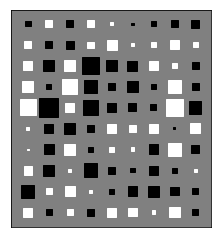

In [165]:
"""
We generate 100 data points in d = 10 dimensions from a Gaussian distribution 
having standard deviations of (5, 4, 3, 2) along four orthogonal directions 
and a standard deviation of 1 in the remaining five directions
"""
m = tdist.multivariate_normal.MultivariateNormal(torch.zeros(10, dtype=torch.float64), torch.diag(torch.DoubleTensor([5,4,3,2,1,1,1,1,1,1])))
X = m.sample(sample_shape=torch.Size([100])).t()

"""
Hinton diagram of <W> from variational Bayesian PCA 
"""
test = BayesianPCA()
test.fit(X) 
hinton(test.mean_w.t().detach().numpy())